## Import der benötigten Software Pakete

In [1]:
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from icl_lens_sizing.preprocessing.preprocessing import prepare_training_data

## Laden und Vorbereiten der Datensätze

In [2]:
path = "/Users/sortmanns/git/work/icl-lens-sizing/data/icl_data_2.csv"
df = pd.read_csv(path, sep=";", decimal=',')
df.head(10)

,befund_id,geschlecht,alter,auge,implantat_name,implantat_größe,Lens-ICPL-Distance,ACD,ACA_nasal,ACA_temporal,AtA,ACW,ARtAR_LR,StS,StS_LR,CBID,CBID_LR,mPupil,WtW_MS-39,WtW_IOL_Master,Sphaere,Zylinder,Achse,Referenz_Id
0,1,w,40.0,OD,IPCL V2.0,12.5,571,3.22,40.443,41.129,11.970,11.654,99,11.847,321,10.813,784,6.85,11.53,11.9,-6.5,-0.25,30,2.0
1,2,w,40.0,OS,IPCL V2.0,12.5,649,3.254,41.771,39.057,11.836,11.813,218,11.819,201,10.887,789,6.72,11.44,11.8,-6.75,-0.5,100,1.0
2,3,w,23.0,OD,IPCL V2.0,13,470,2.808,39.743,44.425,12.025,11.931,152,10.738,672,10.378,1.156,7.05,11.7,12.1,-6.75,-0.5,30,4.0
3,4,w,23.0,OS,IPCL V2.0,13,707,2.91,38.671,35.143,12.013,12.091,38,11.253,464,10.598,1.01,6.83,11.84,12.3,-6.25,-0.5,180,3.0
4,5,w,37.0,OD,IPCL V2.0,13.25,571,3.253,48.729,46.8,12.581,12.191,75,12.666,344,11.642,977,6.87,12.08,12.5,-10.25,-0.25,174,6.0
5,6,w,37.0,OS,IPCL V2.0,13.25,615,3.272,35.329,33.5,12.704,12.348,58,12.768,427,11.529,923,6.83,12.08,12.4,-11.5,-0.75,170,5.0
6,7,m,35.0,OD,IPCL V2.0,13,746,3.417,48.367,49.6,11.961,10.891,88,11.45,471,10.877,873,5.46,11.67,12.1,-5.25,-1,165,8.0
7,8,m,35.0,OS,IPCL V2.0,13,769,3.45,53.36,52.68,11.979,11.013,71,11.929,0.44,11.25,797,5.18,11.76,12.3,-5.75,-0.5,151,7.0
8,9,w,31.0,OS,IPCL V2.0,13.25,501,3.324,51.8,45.1,12.176,10.805,132,12.441,436,12.047,1.097,6.86,11.58,12.1,-4.5,-0.5,175,10.0
9,10,w,31.0,OD,IPCL V2.0,13.25,490,3.348,45.15,46.8,12.178,10.924,85,12.315,501,11.774,977,6.19,11.9,12.2,-3.5,-1.5,120,9.0


# Initiale Untersuchung der Einflussvariablen (Features)
Wir beginnen mit der vollen Feature-Menge, teilen die Daten in Feature- und Zielvariablen.

In [3]:
# Feature Auswahl
features = ['implantat_größe', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']

# Feature Engineering
custom_features = None
# Präparieren der Datensätze zur Weiterverarbeitung
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,
                                                               custom_features=custom_features)

full_df = pd.concat([feature_df,target_df], axis=1)

### Berechnen der (Pearson-)Korrelationsmatrix und Visualisierung der Heatmap
Die Pearson Korrelation gibt uns Hinweise auf einen linearen(!) Zusammenhang zwischen Variablen. Eine hohe Korrelation mit der Zielvariablen ist wünschenswert. Eine hohe Korrelation zwischen den einzelnen Features hingegen ist nicht erwünscht.

Wir standardisieren die Features und beginnen dann mit dem Berechnen der (Pearson-)Korrelationsmatrix und der
Visualisierung der Heatmap. Das Standardisieren der Features hilft die Einflüsse der einzelnen Features besser zu verstehen.

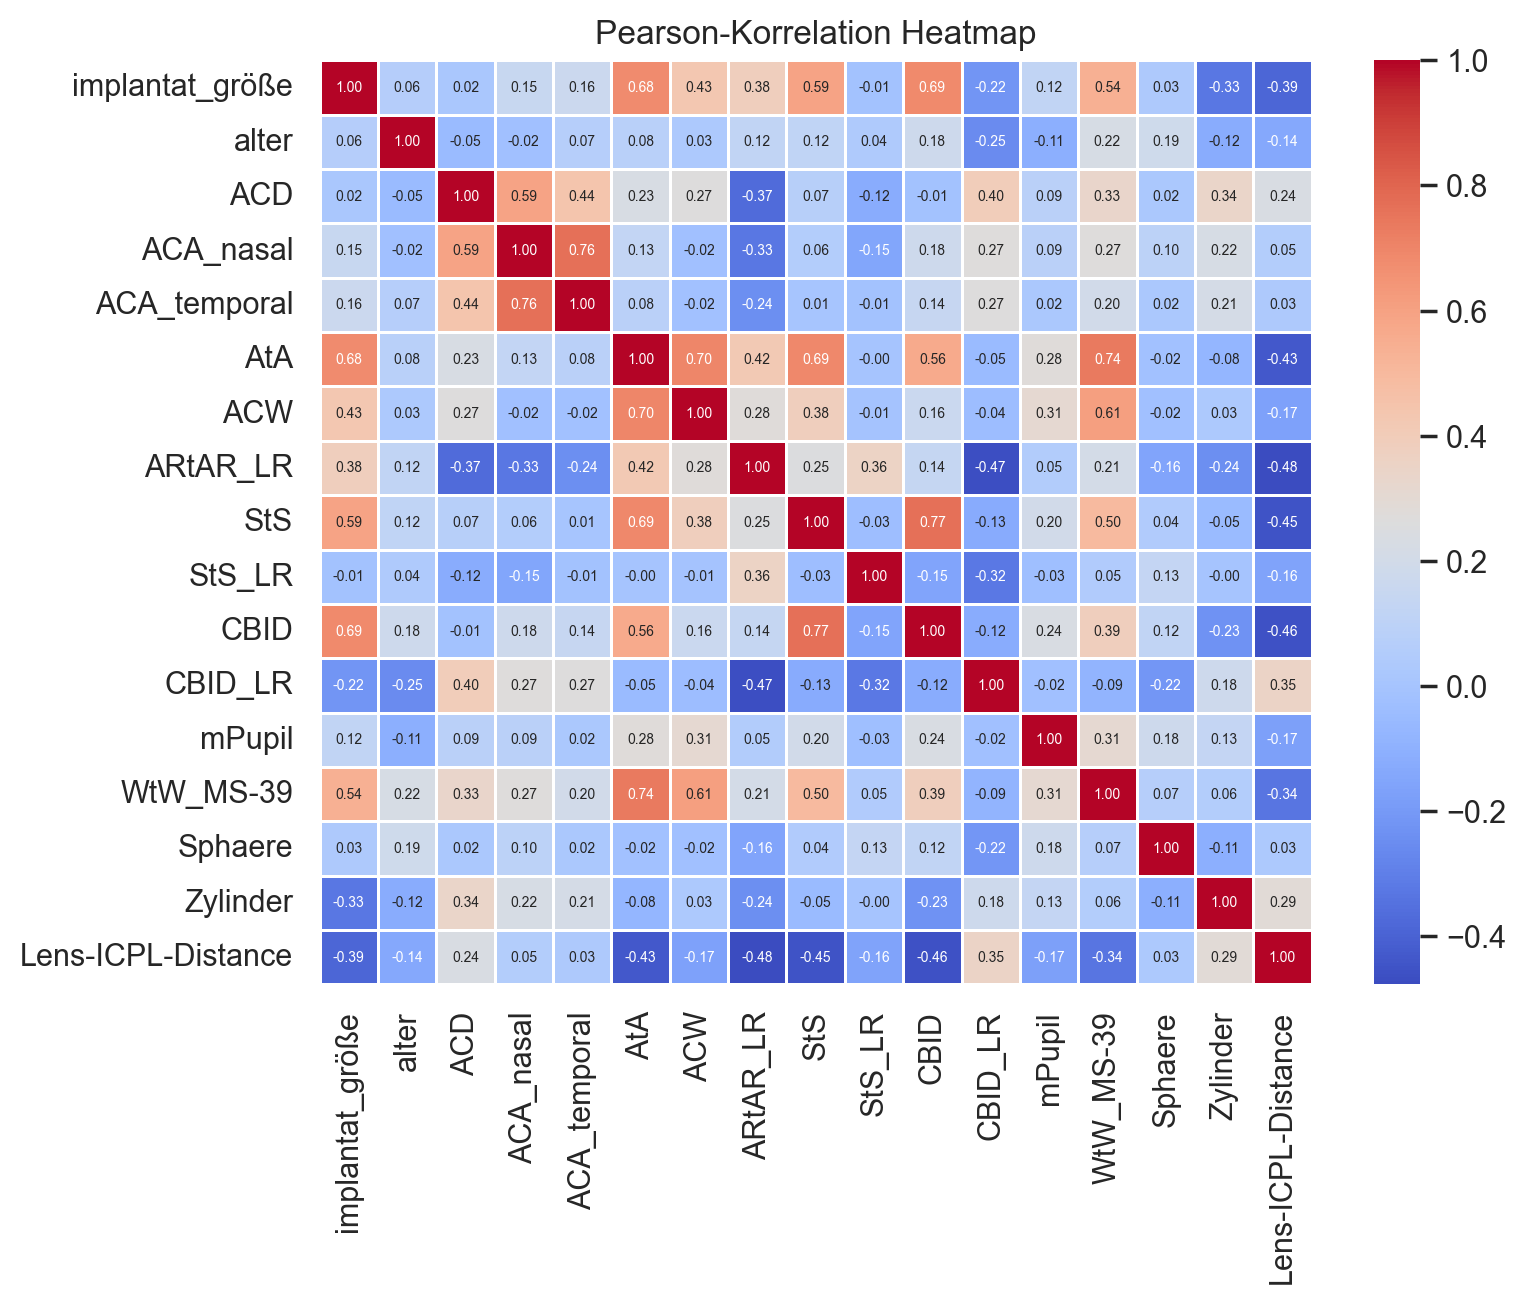

In [4]:
# Store column names
column_names = full_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(full_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

scaled_corr_matrix = scaled_df.corr()

# Heatmap erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(scaled_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 5})
plt.title('Pearson-Korrelation Heatmap')
plt.show()

### Untersuchung der Varianz der Features
Die Varianz eines Features kann uns Hinweise auf die Aussagekraft für das spätere Modell geben. Initial ist es
üblich Features mit hoher Varianz zu wählen. Um die Varianzen besser Vergleichen zu können normieren wir die Features vorher.

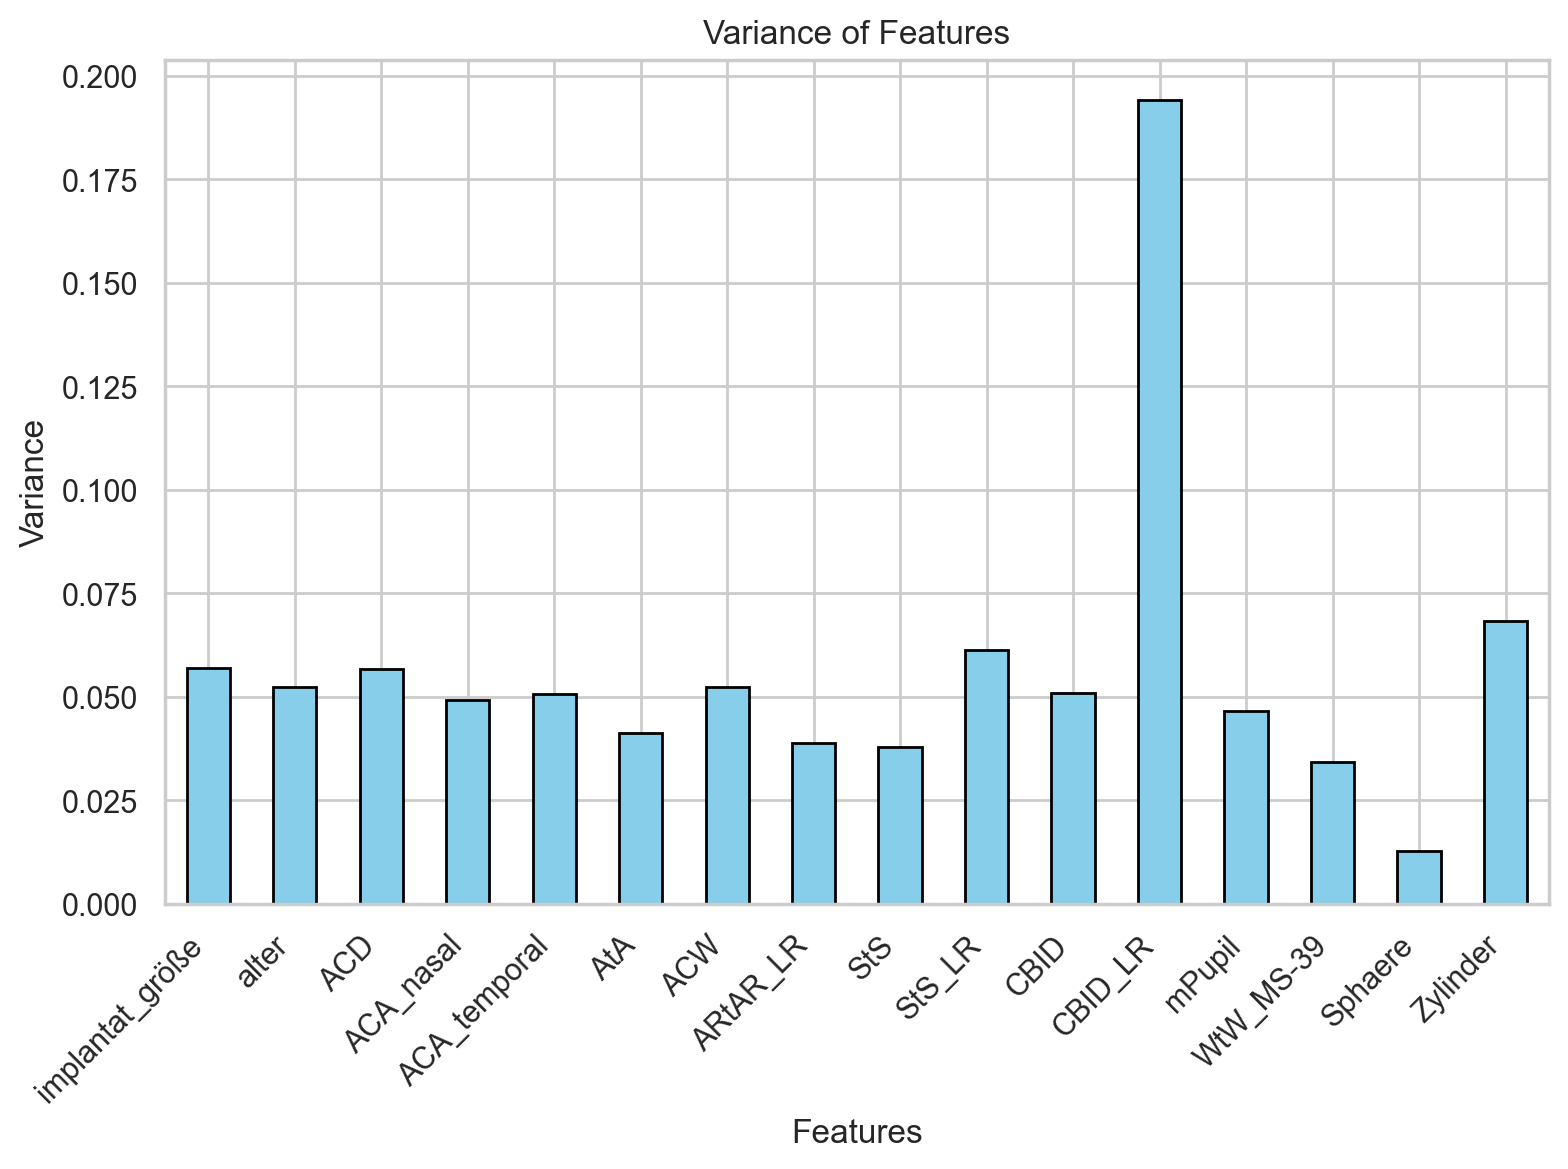

In [5]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the DataFrame using the scaler
normalized_data = scaler.fit_transform(feature_df)

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=column_names[:-1])
# Calculate the variance of each feature
variance = normalized_df.var()

# Plot the variance
plt.figure(figsize=(8, 6))
variance.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Variance of Features')
plt.tight_layout()
plt.show()

## OLS Regression auf der vollen Featuremenge.

In [6]:
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Lens-ICPL-Distance   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.452
Date:                Tue, 10 Oct 2023   Prob (F-statistic):           5.55e-06
Time:                        09:01:26   Log-Likelihood:                -556.62
No. Observations:                  88   AIC:                             1147.
Df Residuals:                      71   BIC:                             1189.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             564.7273     16.038     35.212      0.000     532.749     596.706
implantat_größe    63.3686     31.420      2.017      0.047       0.719     126.019
alter              12.2926     19.349      0.635      0.527     -26.288      50.873
ACD                33.1866     24.858      1.335      0.186     -16.379      82.752
ACA_nasal         -13.1761     30.515     -0.432      0.667     -74.022      47.670
ACA_temporal      -20.7131     27.286     -0.759      0.450     -75.120      33.694
AtA               -31.6937     39.521     -0.802      0.425    -110.496      47.108
ACW                15.3151     27.639      0.554      0.581     -39.796      70.426
ARtAR_LR          -45.8175     26.591     -1.723      0.089     -98.838       7.203
StS               -26.6487     31.119     -0.856      0.395     -88.698      35.400
StS_LR            -10.8914     19.422     -0.561      0.577     -49.617      27.834
CBID              -55.7899     36.931     -1.511      0.135    -129.428      17.848
CBID_LR            37.2310     21.899      1.700      0.093      -6.433      80.895
mPupil            -11.4446     19.429     -0.589      0.558     -50.184      27.295
WtW_MS-39         -43.1183     28.680     -1.503      0.137    -100.304      14.068
Sphaere            22.4484     18.688      1.201      0.234     -14.815      59.712
Zylinder           44.8221     19.974      2.244      0.028       4.994      84.650
==============================================================================
Omnibus:                        5.624   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.211
Skew:                           0.431   Prob(JB):                       0.0739
Kurtosis:                       3.823   Cond. No.                         6.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Berechnen der Modelgüte auf ungesehenen Daten in einem simulierten Szenario mittels Kreuzvalidierung

In [7]:
standard_scaler = StandardScaler()
linear_model = LinearRegression()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', linear_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

161.04817680584264


Wir benutzen Lasso Regression auf derselben Feature-Menge, um die Kollinearität besser zu kontrollieren.
Dann benutzen wir Kreuzvalidierung zum Evaluieren der Modellgüte.

In [8]:
standard_scaler = StandardScaler()
lasso_model = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', lasso_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

156.7031222223562


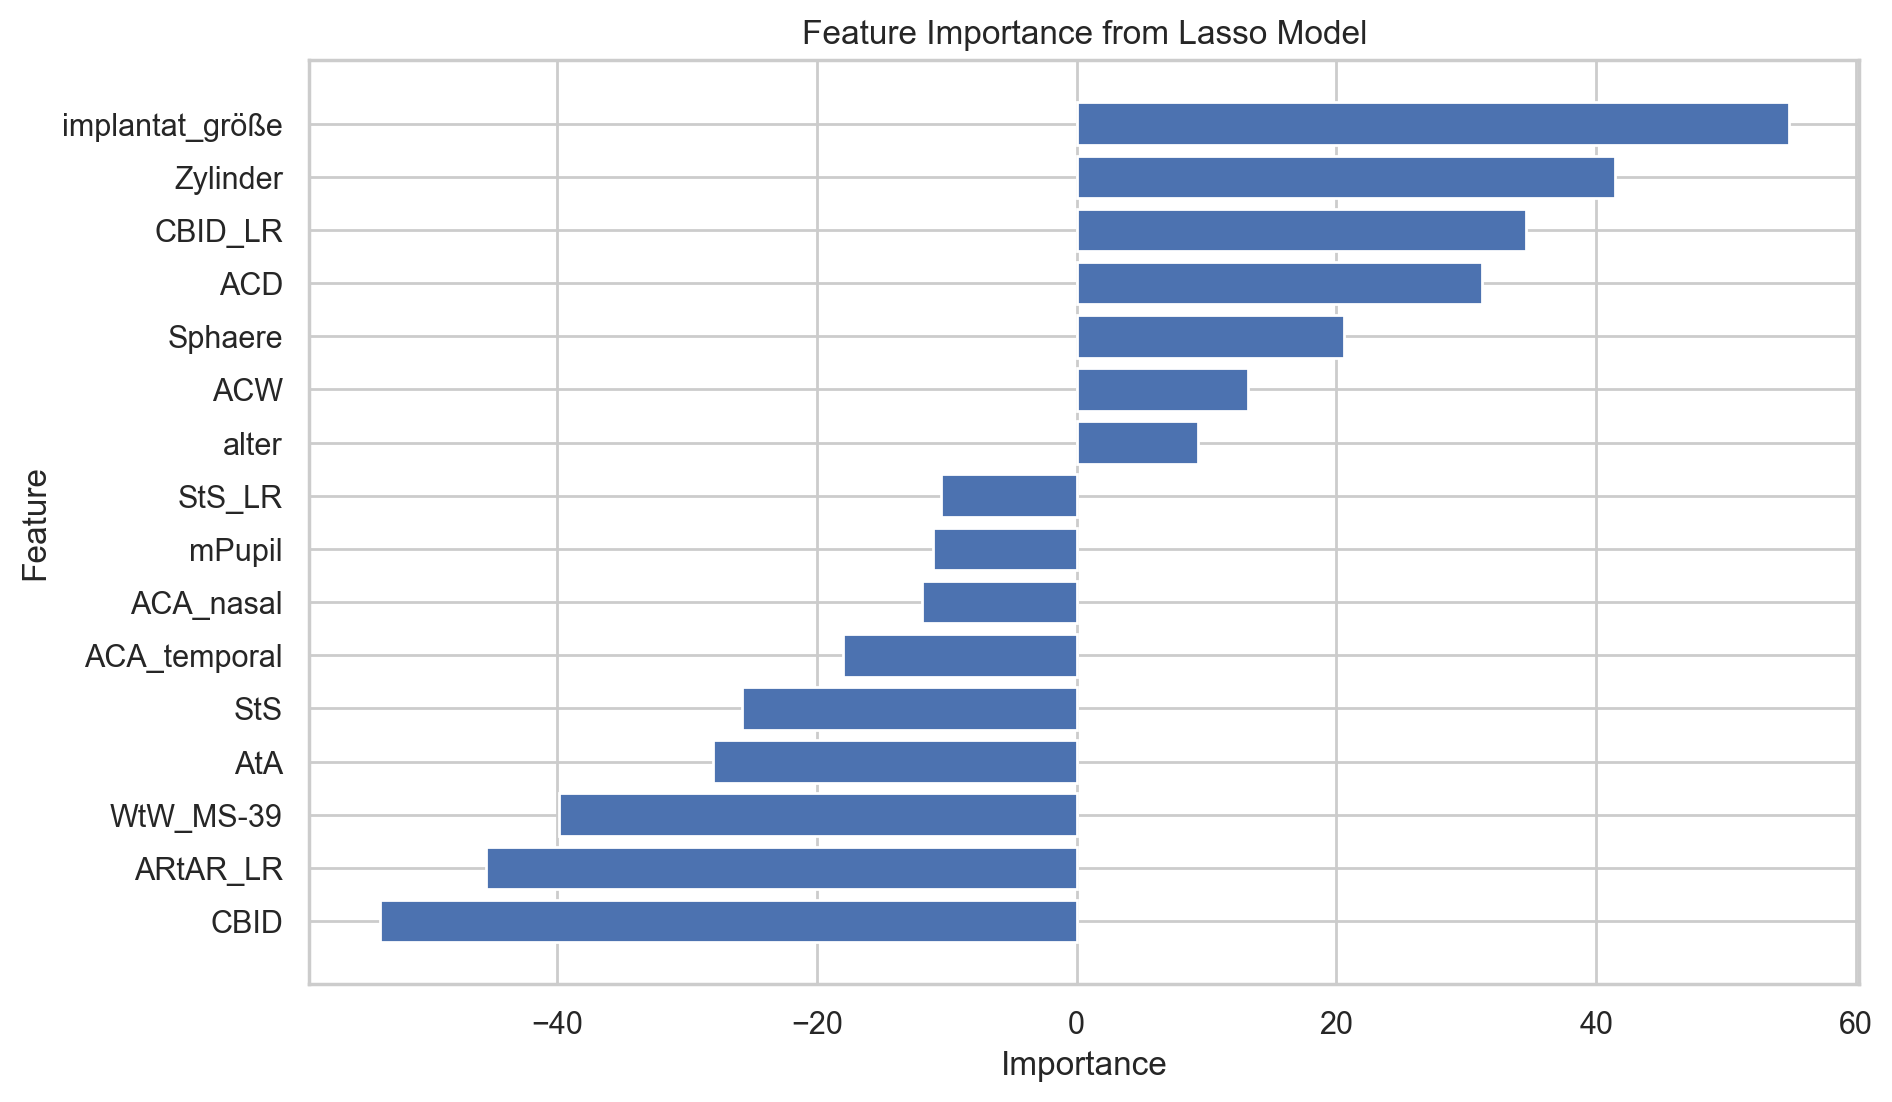

In [9]:
# Fit the pipeline on your data
pipeline.fit(feature_df, target_df)

# Get the Lasso model from the pipeline
lasso_model = pipeline.named_steps['estimator']

# Get the feature importance (coefficients) from the Lasso model
feature_importance = lasso_model.coef_

# Create a DataFrame to hold feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({'Feature': feature_df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

## Sequential Feature Selection

In [10]:
# prepare data
features = ['implantat_größe', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']

custom_features = None
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

linear_model = LinearRegression()
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
sfsb = SequentialFeatureSelector(
    estimator=linear_model,
    direction="backward",
    scoring="neg_mean_absolute_error"
)
sfsb.fit(feature_df, target_df)

/Users/sortmanns/mambaforge/envs/icl-sizing/lib/python3.8/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


SequentialFeatureSelector(direction='backward', estimator=LinearRegression(),
                          scoring='neg_mean_absolute_error')

In [11]:
sfsb.get_feature_names_out()

array(['implantat_größe', 'ACA_temporal', 'ARtAR_LR', 'StS', 'CBID',
       'CBID_LR', 'Sphaere', 'Zylinder'], dtype=object)

In [12]:
features = ['implantat_größe', 'ACA_temporal', 'ARtAR_LR', 'StS', 'CBID',
       'CBID_LR', 'Sphaere', 'Zylinder']

custom_features = None
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Create a StandardScaler object
standard_scaler = StandardScaler()
linear_model = LinearRegression()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', linear_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

117.12433837084488


In [ ]:
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object

scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()
est.summary()

In [14]:
linear_model = LinearRegression()
features = ['implantat_größe', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']

custom_features = None
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
sfsf = SequentialFeatureSelector(
    estimator=linear_model,
    direction="forward",
    scoring="neg_mean_absolute_error"
)
sfsf.fit(feature_df, target_df)
sfsf.get_feature_names_out()

/Users/sortmanns/mambaforge/envs/icl-sizing/lib/python3.8/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


array(['implantat_größe', 'AtA', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
       'CBID_LR', 'Sphaere'], dtype=object)

In [15]:
features = ['implantat_größe', 'AtA', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
       'CBID_LR', 'Sphaere']
custom_features = None
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Create a StandardScaler object
standard_scaler = StandardScaler()
linear_model = LinearRegression()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', linear_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

122.1246666822235


In [16]:
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Lens-ICPL-Distance   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     7.386
Date:                Tue, 10 Oct 2023   Prob (F-statistic):           2.45e-07
Time:                        09:01:29   Log-Likelihood:                -575.11
No. Observations:                  90   AIC:                             1168.
Df Residuals:                      81   BIC:                             1191.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             566.5333     16.022     35.360      0.000     534.655     598.412
implantat_größe    30.1008     26.848      1.121      0.266     -23.318      83.519
AtA               -41.1280     34.008     -1.209      0.230    -108.793      26.537
ACW                16.4785     25.037      0.658      0.512     -33.338      66.295
ARtAR_LR          -61.9499     22.099     -2.803      0.006    -105.920     -17.980
StS                -8.3951     29.198     -0.288      0.774     -66.490      49.700
CBID              -68.5558     32.121     -2.134      0.036    -132.466      -4.645
CBID_LR            35.9413     20.046      1.793      0.077      -3.944      75.827
Sphaere            12.5645     17.442      0.720      0.473     -22.139      47.268
==============================================================================
Omnibus:                       13.473   Durbin-Watson:                   1.378
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.889
Skew:                           0.703   Prob(JB):                     0.000130
Kurtosis:                       4.672   Cond. No.                         5.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Feature Engineering

In [20]:
feature_df.head(10)

,implantat_größe,AtA,ACW,ARtAR_LR,StS,CBID,CBID_LR,Sphaere
0,12.5,11.970,11.654,99,11.847,10.813,784,-6.5
1,12.5,11.836,11.813,218,11.819,10.887,789,-6.75
2,13,12.025,11.931,152,10.738,10.378,1.156,-6.75
3,13,12.013,12.091,38,11.253,10.598,1.01,-6.25
4,13.25,12.581,12.191,75,12.666,11.642,977,-10.25
5,13.25,12.704,12.348,58,12.768,11.529,923,-11.5
6,13,11.961,10.891,88,11.45,10.877,873,-5.25
7,13,11.979,11.013,71,11.929,11.25,797,-5.75
8,13.25,12.176,10.805,132,12.441,12.047,1.097,-4.5
9,13.25,12.178,10.924,85,12.315,11.774,977,-3.5


In [21]:
features = ['implantat_größe', 'ACA_temporal', 'ARtAR_LR', 'StS', 'CBID',
       'CBID_LR', 'Sphaere', 'Zylinder']
sts_cbid = (lambda row: (row['StS'] + row['CBID'])/2)
custom_features = {'sts_cbid':sts_cbid}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Create a StandardScaler object
feature_df = feature_df.drop(columns=['StS', 'CBID'])
standard_scaler = StandardScaler()
linear_model = LinearRegression()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', linear_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

implantat_größe    object
AtA                object
ACW                object
ARtAR_LR           object
StS                object
CBID               object
CBID_LR            object
Sphaere            object
dtype: object


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()
est.summary()

In [ ]:
# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

scaled_corr_matrix = scaled_df.corr()

# Heatmap erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(scaled_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 5})
plt.title('Pearson-Korrelation Heatmap')
plt.show()

In [23]:
features = ['implantat_size', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
        'Sphaere']
sts_cbid = (lambda row: (row['StS'] + row['CBID'])/2)
custom_features = {'sts_cbid':sts_cbid}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Create a StandardScaler object
feature_df = feature_df.drop(columns=['StS', 'CBID'])
standard_scaler = StandardScaler()
linear_model = LinearRegression()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', linear_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

122.35191194905269


In [ ]:
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
est = sm.OLS(target_df, X_ols).fit()
est.summary()

In [ ]:
# # Set the target value
# target_value = 500
#

In [ ]:
# df = pd.read_csv("../data/Vault_postOP.csv", sep=";")
# df["Differenz zu 500"].to_numpy()
#

In [ ]:
# radii = np.abs(df["Differenz zu 500"].to_numpy())
# angles = np.random.uniform(0, 2 * np.pi, len(radii))
# x_discrepancies = radii * np.cos(angles)
# y_discrepancies = radii * np.sin(angles)
#
# # Calculate the actual values
# x_actuals = target_value + x_discrepancies
# y_actuals = target_value + y_discrepancies
#
# # Create a scatter plot
# plt.figure(figsize=(8, 8))
# plt.scatter(x_actuals, y_actuals, c='blue', s=30, alpha=0.5, label='Actual Values')
# plt.axhline(target_value, color='red', linestyle='--', linewidth=2, label='Target Value')
# plt.axvline(target_value, color='red', linestyle='--', linewidth=2)
# plt.xlabel('X Actual Values')
# plt.ylabel('Y Actual Values')
# plt.title('Accuracy Visualization with Crosshair Pattern')
# plt.legend()
# plt.grid(True)
#
# # Display the plot
# plt.show()
#

In [ ]:
# # Create a figure and axis
# fig, ax = plt.subplots()
#
# # Define the center
# center = (500, 500)
#
# # Define the number of circles and the distance between them
# num_circles = 3
# distance_between_circles = 100
# circle_colors = []
# # Draw three red dotted circles with the specified center and distances
# for i in range(num_circles):
#     radius = (i + 1) * distance_between_circles
#     circle = plt.Circle(center, radius, color='red', fill=False, linestyle='dotted')
#     ax.add_artist(circle)
#
#     # Determine the color based on the radius
#     if radius < 100:
#         circle_colors.append('green')
#     elif 100 <= radius <= 250:
#         circle_colors.append('orange')
#
# # Set the aspect ratio to be equal (so circles look like circles)
# ax.set_aspect('equal')
#
# # Set the axis limits
# ax.set_xlim(100, 900)
# ax.set_ylim(100, 900)
#
# # Plot the points from the previous example
# # You can modify these coordinates based on your data
# plt.scatter(x_actuals, y_actuals, c='blue', s=30, alpha=0.5, label='Actual Values')
#
# # Fill the circles with their respective colors
# for i, color in enumerate(circle_colors):
#     ax.add_patch(plt.Circle(center, (i + 1) * distance_between_circles, color=color, alpha=0.2))
#
# # Set axis labels and title
# ax.set_xlabel('achieved vault')
# ax.set_ylabel('achieved vault')
# ax.set_title('ICL Surgery Precision')
#
# # Show the plot
# plt.grid(True)
# plt.legend()
# plt.show()